In [1]:
#Assignment 1
#Course: Derivatives
#Course Code: FINA60206A
#Instructor Name: Pascal François
#Group Members:
#    - YanQing Lin 11345130
#    - Fang Si Tang 11336740
#Submission Date: 2024-10-07

In [2]:
# Initialization
# Reset all variables in the current Jupyter Notebook environment

%reset -f

In [3]:
# Import necessary libraries

import numpy as np
import math
from datetime import datetime
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution

In [4]:
# Import giving parameters

S = 35.66 # Spot price
F = 35.77
r_3month = 0.0406 # 3-month T-bill rate

# Find the continuously compounded and annualized risk-free rate
r = 4 * math.log(1 + r_3month / 4) #risk-free rate continuously compounded and annualized

# Find the time to maturity from 2024-09-12 to 2024-12-20
start_date = datetime(2024, 9, 12)
end_date = datetime(2024, 12, 20)
days_diff = (end_date - start_date).days
t = 0
T = days_diff / 365  #time to maturity

K = np.array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
premiums = np.array([0.13, 0.20, 0.26, 0.32, 0.40, 0.69, 1.08, 1.70, 2.58, 3.65])

In [5]:
# Question 1
#Define and calculate dividend yield using cash-and-carry relation

# Define function calculating the dividend yield from the cash-and-carry relation
def find_y(F, S, r, T, t):
    return r - np.log(F / S) / (T - t)

# Find the dividend yield
y = find_y(F, S, r, T, t) #continuously compounded dividend yield

# Print the result
print(f"Dividend yield (y): {y}")

Dividend yield (y): 0.029040001284251882


In [6]:
# Question 2
# Define Black-Scholes formula and calculate implied volatilities

# Define Black-Scholes formula for put option price
def BSPut(S, K, T, r, y, sigma):
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-y * T) * norm.cdf(-d1)
    return put_price

In [7]:
# Define a function to calculate the implied volatility
def implied_volatility(S, K, T, r, y, premiums):
    
    def objective_function(sigma):
        return premiums - BSPut(S, K, T, r, y, sigma)

    iv = brentq(objective_function, 1e-5, 5)
    return iv

In [8]:
# Find the length for the loop
n = len(K)

# Initialize arrays for S/K ratios and implied volatilities
S_K = np.zeros(n)
iv = np.zeros(n)

# Iterate for n times to calculate S/K ratio and implied volatility
for i in range(0, n):
    S_K[i] = S/K[i] # Calculate the S/K ratio
    iv[i] = implied_volatility(S, K[i], T, r, y, premiums[i]) # Calculate the implied volatility

# Create a table to display the result
data = {'Strike': K, 'Premium': premiums, 'S/K': S_K, 'Implied Volatility': iv}
table_IV = pd.DataFrame(data)

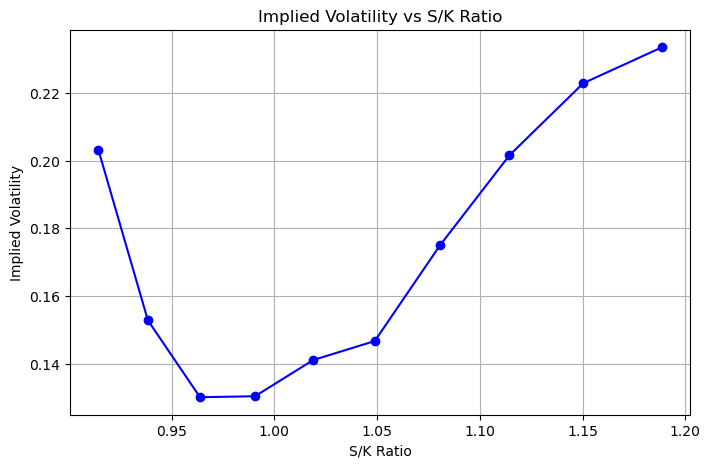

,Strike,Premium,S/K,Implied Volatility
0,30,0.13,1.188667,0.233450
1,31,0.20,1.150323,0.222836
2,32,0.26,1.114375,0.201560
3,33,0.32,1.080606,0.175029
4,34,0.40,1.048824,0.146750
5,35,0.69,1.018857,0.141151
6,36,1.08,0.990556,0.130471
7,37,1.70,0.963784,0.130179
8,38,2.58,0.938421,0.152861
9,39,3.65,0.914359,0.203104


In [9]:
# Plot implied volatilities versus moneyness
plt.figure(figsize = (8, 5))
plt.plot(S_K, iv, marker = 'o', linestyle = '-', color = 'b')
plt.xlabel('S/K Ratio')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs S/K Ratio')
plt.grid(True)
plt.show()

table_IV

In [10]:
# Question 3
# Define Barone-Adesi model calculations

# Define Black-Scholes formula for put option price
def bs_put(S, K, r, y, T, sigma):
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    p = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-y * T) * norm.cdf(-d1)
    return p

# Define Barone-Adesi approximation for American put option

def find_S(S, K, r, y, T, t, sigma):

    # Calculate alpha and beta coefficients for the formula
    alpha = 2 * r / sigma ** 2
    beta = 2 * (r - y) / sigma ** 2
    tau = T - t

    # Calculate the discount factor
    def h(tau):
        return 1 - np.exp(-r * tau)
        
    l1 = 0.5 * (-(beta - 1) - np.sqrt((beta - 1) ** 2 + 4 * alpha / h(tau))) # gama 1
    # Define d1 and d2
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate the European put option price
    p = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-y * T) * norm.cdf(-d1)

    return p - (S / l1) * (1 - np.exp(-y * (T - t)) * norm.cdf(-d1)) - K + S


In [11]:
# function which finds the premium of the put option using Barone-Adesi approx.
def price_put_BA(S, K, r, y, T, t, sigma):

    # Calculate alpha and beta coefficients for the formula
    alpha = 2 * r / sigma ** 2
    beta = 2 * (r - y) / sigma ** 2
    tau = T - t

    # Use fsolve to find an optimized value for S used as better initial guess for S_optim
    S_optim = fsolve(find_S, S, args=(K, r, y, T, t, sigma))
    S_optim = S_optim.item()  # get native type
    
    # Compare S_optim and S
    if S_optim >= S:
        return K - S
    else:
        l1 = 0.5 * (-(beta - 1) - np.sqrt((beta - 1) ** 2 + 4 * alpha / (1 - np.exp(-r * tau))))
        d1 = (np.log(S_optim / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        A1 = -(S_optim / l1) * (1 - np.exp(-y * (T - t)) * norm.cdf(-d1))
        return bs_put(S, K, r, y, T, sigma) + A1 * (S / S_optim) ** l1

In [12]:
# Initialize arrays for the put option premiums by using Barone-Adesi approximation
premium_BA = np.zeros(n)

# Calculate the American put option premium
for i in range(0, n):

    premium_BA[i] = price_put_BA(S, K[i], r, y, T, t, iv[i])


In [13]:
# Create a table to display the result
data = {'Strike': K, 'Premium': premiums, 'American Option Premium (BA)': premium_BA}
table_BA = pd.DataFrame(data)

table_BA

,Strike,Premium,American Option Premium (BA)
0,30,0.13,0.131037
1,31,0.20,0.201421
2,32,0.26,0.261818
3,33,0.32,0.322341
4,34,0.40,0.403238
5,35,0.69,0.695618
6,36,1.08,1.090104
7,37,1.70,1.718514
8,38,2.58,2.607273
9,39,3.65,3.680465


In [14]:
# Question 4
# Create a binomial tree model for American put options

def american_put_option_crr(N, S, K, r, sigma, y, T):
    # Define variables
    dt = T / N  # Time step size
    u = math.exp(sigma * math.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (math.exp((r - y) * dt) - d) / (u - d)  # Risk-neutral probability of upward
    q = 1 - p # Risk-neutral probability of downward
    

    # Generate the stock price binomial tree
    Sn = np.zeros((N+1, N+1)) # Stock price binomial tree

    for i in range(0, N+1):
        for j in range(0, i+1):
            Sn[i,j] = S * (u ** j) * (d ** (i - j))
    # print (Sn)

    # Generate the intrinsic values
    Gn = np.zeros((N+1, N+1))
    for i in range(0, N+1):
        for j in range(0, i+1):
            Gn[i,j] = max(K - Sn[i,j], 0)
    # print (Gn)

    # Generate the put option price
    Pn = np.zeros((N+1, N+1))

    Pn[N,:] = Gn[N,:]

    # Step backward through the binomial tree
    for i in range(N-1, -1, -1):  # Loop from N-1 down to 0
        for j in range(0, i+1):
    # Discounted expected value at the current node
            Pn[i,j] = max(Gn[i,j], math.exp(-r * dt) * (p * Pn[i+1,j + 1] + (q * Pn[i+1,j])))

    # print (Pn)
    
    # The price of the put option at time 0
    P0 = Pn[0,0]
    return P0

In [15]:
# Set the number of steps to 1000 
N = 1000

# Initialize arrays for the put option premiums by using CRR binomial tree
n = len(K)
Put_CRR = np.zeros(n)

# Calculate the American put option premium
for i in range(0, n):
    
    Put_CRR[i] = american_put_option_crr(N, S, K[i], r, iv[i], y, T)

In [16]:
# Create a table to display the result and compare the results for BAW and CRR 
data = {'Strike Price': K, 'Premium': premiums, 'American Option Premium (BA)': premium_BA, 'American Option Premiun (CRR)': Put_CRR}
table_CRR = pd.DataFrame(data)
table_CRR

,Strike Price,Premium,American Option Premium (BA),American Option Premiun (CRR)
0,30,0.13,0.131037,0.130442
1,31,0.20,0.201421,0.200539
2,32,0.26,0.261818,0.261141
3,33,0.32,0.322341,0.321786
4,34,0.40,0.403238,0.402671
5,35,0.69,0.695618,0.695552
6,36,1.08,1.090104,1.091913
7,37,1.70,1.718514,1.723128
8,38,2.58,2.607273,2.614232
9,39,3.65,3.680465,3.688590


In [17]:
# Question 5
# Adjust Black-Scholes model to include skewness and kurtosis

# Define adjusted BMS function including skewness and kurtosis
def extended_BMS(S, K, T, r, y, sigma, skew, kurt):

    #Determine the theoretical BMS
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    bms_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-y * T) * norm.cdf(-d1)
    
    #Determine the Q3 and Q4
    pdf_d = norm.pdf(d1)
    cdf_d = norm.cdf(d1)

    Q3 = ((S * sigma * np.sqrt(T) / 6) * ((2 * sigma * np.sqrt(T) - d1) * pdf_d + sigma**2 * T * cdf_d))
    Q4 = ((S * sigma * np.sqrt(T) / 24) * ((d1**2 - 1 - 3 * sigma * np.sqrt(T) * (d1 - sigma * np.sqrt(T))) * pdf_d + 3 * sigma**(3/2) * T * cdf_d))
    
    #Determine the extended BMS
    ext_bms = bms_price + skew * Q3 + (kurt - 3) * Q4
       
    return ext_bms

In [18]:
# Define the objective function
def objective_function_ext(x, S, K, T, r, y, premiums):
    
    sigma, skew, kurt = x

    # generate the extended bms prices
    n = len(K)
    ext_bms_price = np.zeros(n)
    for i in range(0, n):
        ext_bms_price[i] = extended_BMS(S, K[i], T, r, y, sigma, skew, kurt)

    error = np.sum((premiums - ext_bms_price)**2)

    return error

In [19]:
# Set parameter bounds to allow searching within a reasonable range
bounds_ext = [(0.0, 2.0), (-2, 2), (0, 8)]  # bounds for sigma, skew, kurt

# Use differential evolution to optimize volatility, skewness, and kurtosis
# Set a seed = 777 for reproducibility
result_diff_evol = differential_evolution(objective_function_ext, bounds_ext, 
                                          args=(S, K, T, r, y, premiums), seed = 777)

# Extract optimized parameter from differential evolution as starting point for local optimization
initial_params = result_diff_evol.x

# Find the optimal volatility, skew and kurt
result_bfgs = minimize(objective_function_ext, initial_params, args=(S, K, T, r, y, premiums), method='L-BFGS-B', bounds=bounds_ext)

# Extract optimized parameters
sigma_opt, skew_opt, kurt_opt = result_bfgs.x
optimal_fun = result_bfgs.fun

# Create a table to display the result
table_opt = pd.DataFrame({'Optimal sigma': [sigma_opt], 'Optimal skew': [skew_opt], 'Optimal kurtosis': [kurt_opt], 'Optimal Value': [optimal_fun]})
table_opt


,Optimal sigma,Optimal skew,Optimal kurtosis,Optimal Value
0,0.168943,-0.023025,8.0,0.03579


In [20]:
# Initialize arrays for the put option premiums by using adjusted BSM
premium_adjusted = np.zeros(n)

# Calculate the American put option premium
for i in range(0, n):
    premium_adjusted[i] = extended_BMS(S, K[i], T, r, y, sigma_opt, skew_opt, kurt_opt)
    

# Create a table to display the result
table_premium = pd.DataFrame({'Market_Premium': premiums, 'Adjusted_BMS': premium_adjusted})
table_premium

,Market_Premium,Adjusted_BMS
0,0.13,0.147399
1,0.20,0.188767
2,0.26,0.223113
3,0.32,0.273639
4,0.40,0.397550
5,0.69,0.665696
6,1.08,1.127128
7,1.70,1.784534
8,2.58,2.596820
9,3.65,3.503015


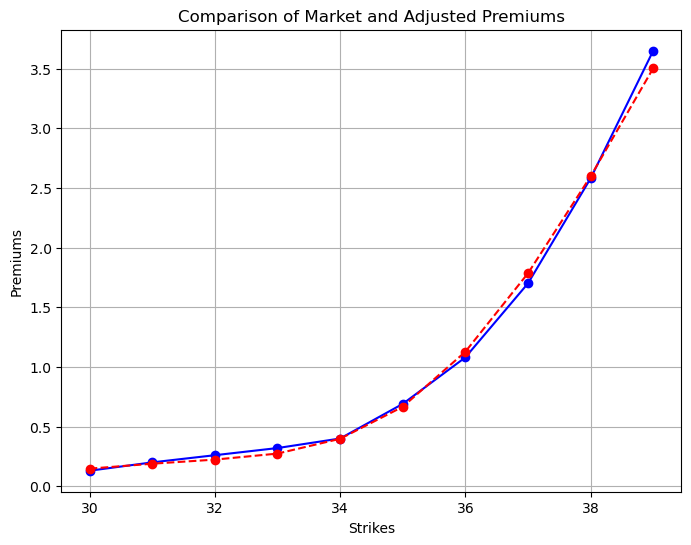

In [21]:
# Plot the adjusted premiums and compare with the market premiums
plt.figure(figsize=(8, 6))
plt.plot(K, premiums, marker='o', linestyle='-', color='blue')
plt.plot(K, premium_adjusted, marker='o', linestyle='--', color='red')

plt.xlabel('Strikes')
plt.ylabel('Premiums')
plt.title('Comparison of Market and Adjusted Premiums')
plt.grid(True)
plt.show()

In [22]:
# Define a function to calculate the implied volatility from the adjusted BSM
def implied_volatility_adj(S, K, T, r, y, premiums, skew, kurt):
    
    def objective_function_iv(sigma):
        return premiums - extended_BMS(S, K, T, r, y, sigma, skew, kurt)

    iv_ext = brentq(objective_function_iv, 1e-5, 3)
    
    return iv_ext

In [23]:
# Initialize arrays for the put option price and implied volalility using adjuested BSM
# Initialize array for the implied volatility ratio
p_ext = np.zeros(n)
iv_ext = np.zeros(n)
iv_ratio = np.zeros(n)

# Calculate the option price, implied volatility and implied volatility ratio
for i in range(0, n):
    p_ext[i] = extended_BMS(S, K[i], T, r, y, sigma_opt, skew_opt, kurt_opt)
    iv_ext[i] = implied_volatility_adj(S, K[i], T, r, y, premiums[i], skew_opt, kurt_opt)
    iv_ratio[i] = iv_ext[i]/iv[i]

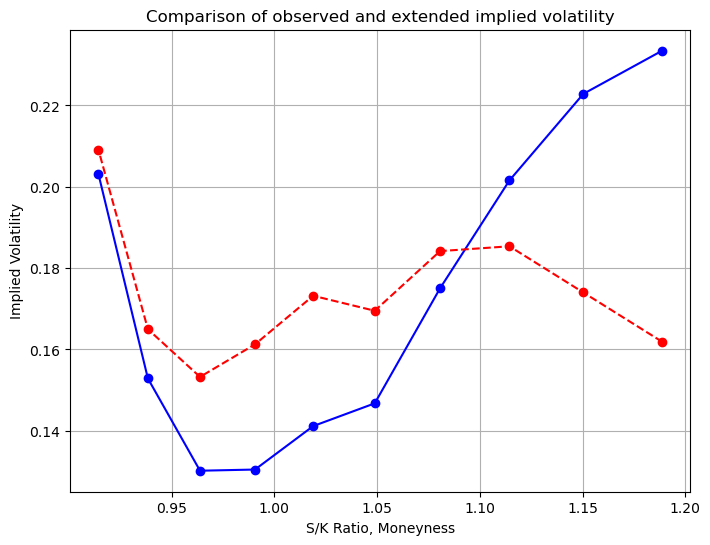

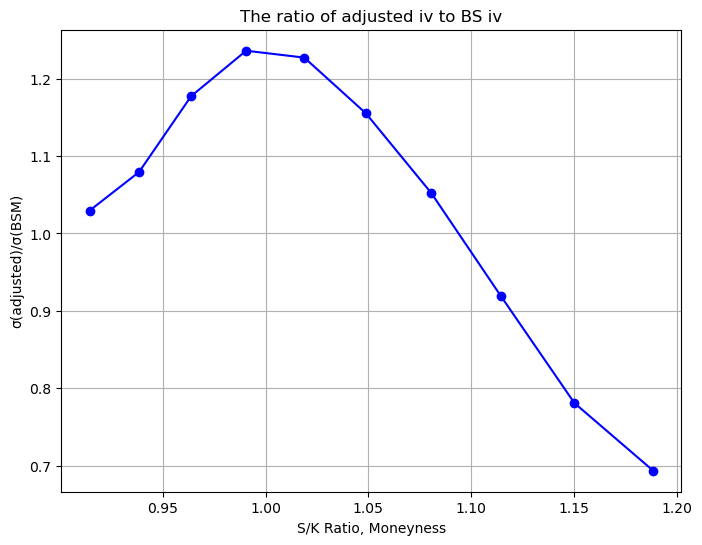

,Strikes,Moneyness,Observed_iv,Adjusted_iv,ratio
0,30,1.188667,0.233450,0.161893,0.693479
1,31,1.150323,0.222836,0.174004,0.780860
2,32,1.114375,0.201560,0.185364,0.919650
3,33,1.080606,0.175029,0.184178,1.052270
4,34,1.048824,0.146750,0.169508,1.155075
5,35,1.018857,0.141151,0.173197,1.227035
6,36,0.990556,0.130471,0.161253,1.235936
7,37,0.963784,0.130179,0.153250,1.177222
8,38,0.938421,0.152861,0.164972,1.079229
9,39,0.914359,0.203104,0.209081,1.029429


In [24]:
# Plot the comparison of observed and extended implied volatilities
plt.figure(figsize=(8, 6))
plt.plot(S_K, iv, marker='o', linestyle='-', color='blue')
plt.plot(S_K, iv_ext, marker='o', linestyle='--', color='red')
plt.xlabel('S/K Ratio, Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Comparison of observed and extended implied volatility')
plt.grid(True)
plt.show()

# Plot the ratio of extended iv to observed iv
plt.figure(figsize=(8, 6))
plt.plot(S_K, iv_ratio, marker='o', linestyle='-', color='blue')
plt.xlabel('S/K Ratio, Moneyness')
plt.ylabel('σ(adjusted)/σ(BSM)')
plt.title('The ratio of adjusted iv to BS iv')
plt.grid(True)
plt.show()

# Create a table to display the result
table_adjIV = pd.DataFrame({'Strikes': K, 'Moneyness': S_K, 'Observed_iv': iv, 'Adjusted_iv': iv_ext, 'ratio': iv_ratio})
table_adjIV

In [25]:
# Question 6
# Define optimization functions for trinomial tree with constraints

# Create the objective function that using the optimized sigma, skew, and kurt as inputs
def create_objective_function(sigma, skew, kurt):
    # Define the objective function to compute iteration values with given parameters
    def objective_fun_trinom(params):
        q1, q2, q3, u, m, d = params

        dt_c = 1 / 3650 # calendar days
        dt_b = 1 / 2520 # trading days
        
        # Calculate the mu1, mu2, mu3, mu4
        mu1 = (r - y) * dt_c
        mu2 = sigma ** 2 * dt_b
        mu3 = skew * dt_b * sigma ** (3 / 2)
        mu4 = kurt * dt_b * sigma ** 4

        # Iterate over n from 1 to 4 to compute the overall error
        iter_value = 0
        for n in range(1, 5):
            term = q1 * u ** n + q2 * m ** n + q3 * d ** n - 1 - n * mu1 - (n ** 2 * mu2) / math.factorial(2) - (n ** 3 * mu3) / math.factorial(3) - (n ** 4 * mu4) / math.factorial(4)
            iter_value += term ** 2

        return iter_value
    return objective_fun_trinom

# Create the constraint for probabilities: q1 + q2 + q3 = 1
def q_constraints(params):
    q1, q2, q3, u, m, d = params
    return q1 + q2 + q3 - 1

# Create the constraints for the multiplier factor: u*d = m^2
def prob_constraints(params):
    q1, q2, q3, u, m, d = params
    return m ** 2 - u * d

# Set parameter bounds to allow searching within a reasonable range
bounds = [
    (0, 1),  # q1
    (0, 1),  # q2
    (0, 1),  # q3
    (0.8, 2.2),  # u - Relaxed bounds for broader search
    (0.3, 1.7),  # m - Relaxed bounds for broader search
    (0, 1)   # d
]

# Define constraints to ensure constraints and non-negativity
epsilon = 1e-6
constraints = [
    {'type': 'eq', 'fun': q_constraints},
    {'type': 'eq', 'fun': prob_constraints},
    {'type': 'ineq', 'fun': lambda params: params[0]},
    {'type': 'ineq', 'fun': lambda params: params[1]},
    {'type': 'ineq', 'fun': lambda params: params[2]}, 
    {'type': 'ineq', 'fun': lambda params: 1 - params[5] - epsilon} # d must be less than 1
]

# Use simulated annealing for global optimization
# Set a seed = 100 for reproducibility
def simulated_annealing(bounds, objective_fun, seed):
    result = dual_annealing(objective_fun, bounds, maxiter=2000, initial_temp=5230, seed = 100)  # Increased maxiter for better exploration
    return result

# Use differential evolution for global optimization
def differential_evolution_optimizer(bounds, objective_fun, seed):
    result = differential_evolution(objective_fun, bounds, popsize=30, mutation=(0.5, 1), recombination=0.9, strategy='best1bin', seed=seed)  # Increased popsize for more diversity
    return result

# Use SLSQP for local search optimization
def local_search(initial_guess, bounds, objective_fun, constraints):
    result = minimize(objective_fun, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP', options={'ftol': 1e-10, 'maxiter': 2000})  # Increased maxiter for improved convergence
    return result

# Multi-algorithm optimization function 
# Find the best solution across multiple starts and algorithms( annealing, differential, local search)
# Ensure that don't get into trouble of local minimization
def multi_algorithm_optimization(n_starts, bounds, objective_fun, constraints, base_seed):
    best_result = None
    algorithms = [simulated_annealing, differential_evolution_optimizer] # global research

    for i in range(n_starts):
        seed = base_seed + i  # Unique seed for each start
        np.random.seed(seed)
        global_optimizer = np.random.choice(algorithms) # one of these algorithms is randomly chosen from annealing and differential evolution
        global_result = global_optimizer(bounds, objective_fun, seed) # global optimization
        initial_guess = global_result.x # set the global optimization as initials for local optimization
        local_result = local_search(initial_guess, bounds, objective_fun, constraints) # local optimization

        if best_result is None or local_result.fun < best_result.fun:
            best_result = local_result #Store the better result

    return best_result

# Input the sigma skew and kurt from Q5 and get the optimized q1 q2 q3 u m d
def optimize_for_single_sigma(sigma, n_starts, base_seed):
    print(f"Optimizing for sigma = {sigma}")
    skew_adjustable = skew_opt  
    kurt_adjustable = kurt_opt  
    objective_fun = create_objective_function(sigma, skew_adjustable, kurt_adjustable)
    seed = base_seed  # Only one seed needed since there's only one sigma
    best_solution = multi_algorithm_optimization(n_starts, bounds, objective_fun, constraints, seed)
    results = {
        'parameters': best_solution.x,
        'objective_value': best_solution.fun
    }
    return results

In [26]:
# Run the optimizer
n_starts = 15  # The number of optimization attempts
offset_seed = 777  # Set a seed = 777 for reproducibility

optimization_results = optimize_for_single_sigma(sigma_opt, n_starts, offset_seed)


Optimizing for sigma = 0.1689425064800195


In [27]:
# Extract the parameters from the results
q1 = optimization_results['parameters'][0]
q2 = optimization_results['parameters'][1]
q3 = optimization_results['parameters'][2]
u = optimization_results['parameters'][3]
m = optimization_results['parameters'][4]
d = optimization_results['parameters'][5]
objective_value = optimization_results['objective_value']

In [28]:
# Create a table to display the result
table_para = pd.DataFrame({'q1': [q1], 'q2': [q2], 'q3': [q3], 'u': [u], 'm': [m], 'd': [d],'objective_value': [objective_value]})

table_para

,q1,q2,q3,u,m,d,objective_value
0,0.068968,0.866643,0.06439,1.010954,0.999949,0.989063,9.194712e-12


In [29]:
# Code for Question 7
# Create a trinomial tree model for American put options

def trinomial(N, S, K, r, sigma, y, T, q1, q2, q3, u, m, d):
    # Define variables
    dt = T / N  # Time step size
    
    # Generate the stock price trinomial tree
    Sn = np.zeros((2*N+1, N+1))  # Stock price trinomial tree

    for i in range(0, 2*N+1):
        for j in range(0, N+1):
            if i < j:
                Sn[i, j] = S * (m ** j) * (u ** (j - i))  # j is the state, i is the time step
            elif i == j:
                Sn[i, j] = S * (m ** j)
            elif i > j and i < 2*j+1:
                Sn[i, j] = S * (m ** (2*j-i)) * (d ** (i - j))
#    # print (Sn)
    
    # Generate the intrinsic values
    Gn = np.zeros((2*N+1, N+1))
    
    for i in range(0, 2*N+1):
        for j in range(0, N+1):
            if i < 2*j+1:
                Gn[i,j] = np.maximum(K - Sn[i,j], 0) # Calculate intrinsic value for each step and state
            else:
                Gn[i,j] = 0
    # print (Gn)

    # Generate the put option price
    Pn = np.zeros((2*N+1, N+1))
    
    # Option value at expiration equals intrinsic value
    Pn[:,N] = Gn[:,N]

    # Step backward through the trinomial tree
    for j in range(N-1, -1, -1):  # Loop from N-1 down to 0
        for i in range(0, 2*N-1):
    # Discounted expected value at the current node
            if i < 2*j+1:
                Pn[i,j] = max(Gn[i,j], np.exp(-r * dt) * (q1 * Pn[i,j + 1] + q2 * Pn[i+1,j + 1] + q3 * Pn[i+2,j + 1]))
    #print (Pn)
    
    # The price of the put option at time 0
    P0 = Pn[0,0]
    return P0

In [30]:
Put_tri = np.zeros(n)

for i in range(0, n):
    
    Put_tri[i] = trinomial(N, S, K[i], r, iv_ext[i], y, T, q1, q2, q3, u, m, d)
    
# Create a table to display the result
data = {'Strike Price (K)': K, 'Premium': premiums, 'American_Premiun_Trinomial': Put_tri}
table_premium = pd.DataFrame(data)
table_premium

,Strike Price (K),Premium,American_Premiun_Trinomial
0,30,0.13,0.144007
1,31,0.20,0.254004
2,32,0.26,0.419919
3,33,0.32,0.654891
4,34,0.40,0.969320
5,35,0.69,1.369862
6,36,1.08,1.863611
7,37,1.70,2.444056
8,38,2.58,3.109960
9,39,3.65,3.849687


In [31]:
# Create a table to compare binomial and trinomial premiums
data = {'Strike Price': K, 'Premium': premiums, 'Implied Volatility': iv, 'American Option Premiun (CRR)': Put_CRR, 
        'Adjusted Implied Volatility': iv_ext, 'American Option Premiun (TRI)': Put_tri}
table_TRI = pd.DataFrame(data)
table_TRI

,Strike Price,Premium,Implied Volatility,American Option Premiun (CRR),Adjusted Implied Volatility,American Option Premiun (TRI)
0,30,0.13,0.233450,0.130442,0.161893,0.144007
1,31,0.20,0.222836,0.200539,0.174004,0.254004
2,32,0.26,0.201560,0.261141,0.185364,0.419919
3,33,0.32,0.175029,0.321786,0.184178,0.654891
4,34,0.40,0.146750,0.402671,0.169508,0.969320
5,35,0.69,0.141151,0.695552,0.173197,1.369862
6,36,1.08,0.130471,1.091913,0.161253,1.863611
7,37,1.70,0.130179,1.723128,0.153250,2.444056
8,38,2.58,0.152861,2.614232,0.164972,3.109960
9,39,3.65,0.203104,3.688590,0.209081,3.849687


In [32]:
# Create a table to display all the premiums calculated from different methods
data = {'Strike Price': K, 'Premium': premiums, 'American Option Premiun (BAW)': premium_BA, 'American Option Premiun (CRR)': Put_CRR, 
        'American Option Premiun (Adjusted_BMS)': premium_adjusted, 'American Option Premiun (TRI)': Put_tri}
table_TRI = pd.DataFrame(data)
table_TRI

,Strike Price,Premium,American Option Premiun (BAW),American Option Premiun (CRR),American Option Premiun (Adjusted_BMS),American Option Premiun (TRI)
0,30,0.13,0.131037,0.130442,0.147399,0.144007
1,31,0.20,0.201421,0.200539,0.188767,0.254004
2,32,0.26,0.261818,0.261141,0.223113,0.419919
3,33,0.32,0.322341,0.321786,0.273639,0.654891
4,34,0.40,0.403238,0.402671,0.397550,0.969320
5,35,0.69,0.695618,0.695552,0.665696,1.369862
6,36,1.08,1.090104,1.091913,1.127128,1.863611
7,37,1.70,1.718514,1.723128,1.784534,2.444056
8,38,2.58,2.607273,2.614232,2.596820,3.109960
9,39,3.65,3.680465,3.688590,3.503015,3.849687


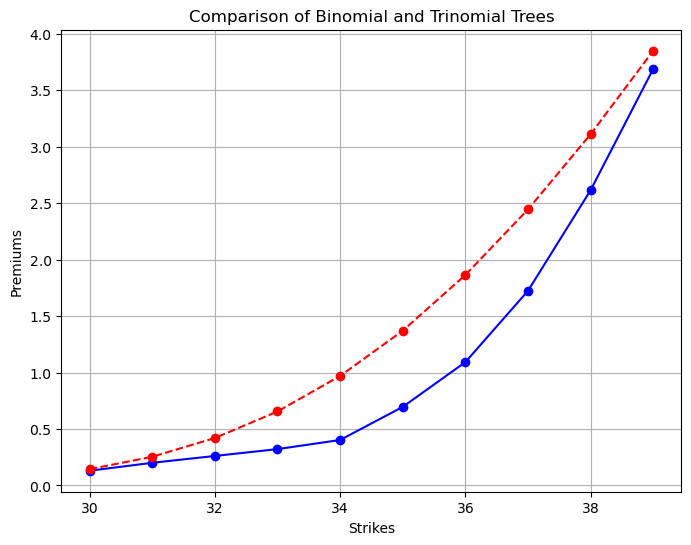

In [33]:
# Plot the comparison of binomial and trinomial results
plt.figure(figsize=(8, 6))
plt.plot(K, Put_CRR, marker='o', linestyle='-', color='blue')
plt.plot(K, Put_tri, marker='o', linestyle='--', color='red')

plt.xlabel('Strikes')
plt.ylabel('Premiums')
plt.title('Comparison of Binomial and Trinomial Trees')
plt.grid(True)
plt.show()

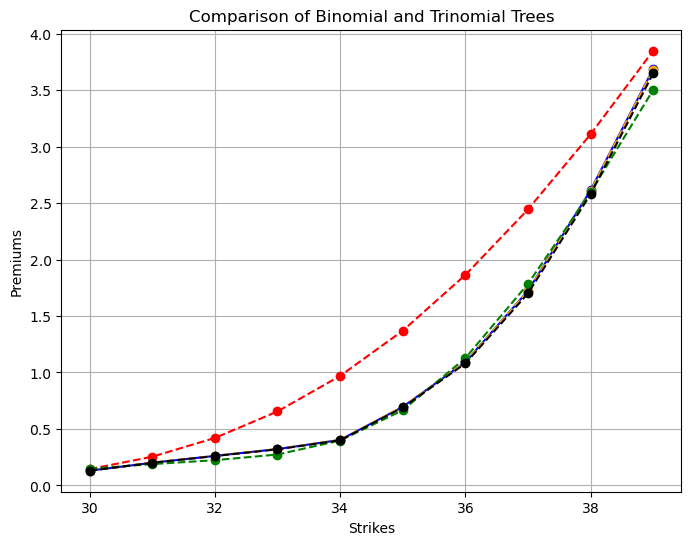

In [34]:
# Plot the comparison of all the results with different methods
plt.figure(figsize=(8, 6))
plt.plot(K, Put_CRR, marker='o', linestyle='-', color='blue')
plt.plot(K, Put_tri, marker='o', linestyle='--', color='red')
plt.plot(K, premium_BA, marker='o', linestyle='--', color='orange')
plt.plot(K, premium_adjusted, marker='o', linestyle='--', color='green')
plt.plot(K, premiums, marker='o', linestyle='--', color='black')
plt.xlabel('Strikes')
plt.ylabel('Premiums')
plt.title('Comparison of Binomial and Trinomial Trees')
plt.grid(True)
plt.show()